In [1]:
import ROOT
import ostap.fixes.fixes
from ostap.core.core import cpp, Ostap
from ostap.core.core import pwd, cwd, ROOTCWD
from ostap.core.core import rootID, funcID, funID, fID, histoID, hID, dsID
from ostap.core.core import VE
from ostap.histos.histos import h1_axis, h2_axes, h3_axes
from ostap.histos.graphs import makeGraph, hToGraph, hToGraph2, hToGraph3, lw_graph
import ostap.trees.trees
import ostap.trees.cuts
import ostap.histos.param
import ostap.histos.compare
import ostap.io.root_file
import ostap.math.models
import ostap.fitting.roofit 
import ostap.fitting.models as Models

Welcome to JupyROOT 6.20/06


TFile**		test_file.root	
 TFile*		test_file.root	
  KEY: RooDataSet	ds_k;1	Ostap.Selectors/ds_1000 
  KEY: TProcessID	ProcessID0;1	4de99c20-f0e9-11e9-ba22-e368b8bcbeef
  KEY: RooDataSet	ds_pi;1	Ostap.Selectors/ds_1000 


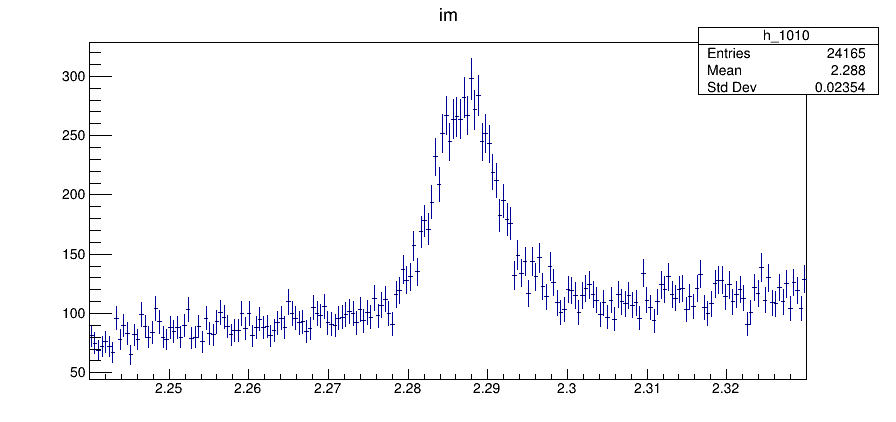

In [2]:
canv = ROOT.TCanvas("canv","canv",900,450)
im  = ROOT.RooRealVar("im" ,"im" , 2.24, 2.33)
lgi = ROOT.RooRealVar("lgi","lgi",-2.50, 2.50)
arg_set = ROOT.RooArgSet(im, lgi)
cut = "im>2.24 && im<2.33 && lgi>-2.5 && lgi<2.5 && NNp>0.5"
rfile = ROOT.TFile("test_file.root","READ")
rfile.ls()
small_ds = rfile["ds_k"].reduce( arg_set, cut)
small_ds.draw("im")
canv.Draw()

In [3]:
lgi_bins = []
LGI = 50
for i in range(LGI+1):
    lgi_bins.append(-2.5 + 5.*i/LGI)


  RooFitResult: minimized FCN value: -279452, estimated distance to minimum: 7.5894e-05
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 HESSE=0 

    Floating Parameter  InitialValue    FinalValue +/-  Error     GblCorr.
  --------------------  ------------  --------------------------  --------
                     B    1.0000e+00    2.0081e+04 +/-  1.78e+02  0.541097
                     S    1.0000e+00    4.0850e+03 +/-  1.25e+02  0.697471
              asym_sig    0.0000e+00   -5.6928e-02 +/-  5.84e-02  0.941434
              beta_sig    1.0000e+00    1.6886e+00 +/-  4.83e-01  0.936373
              mean_sig    2.2870e+00    2.2870e+00 +/-  3.29e-04  0.940776
             sigma_sig    4.5000e-03    3.5904e-03 +/-  2.36e-04  0.920577
               tau_bkg    0.0000e+00    4.3743e+00 +/-  2.77e-01  0.169228




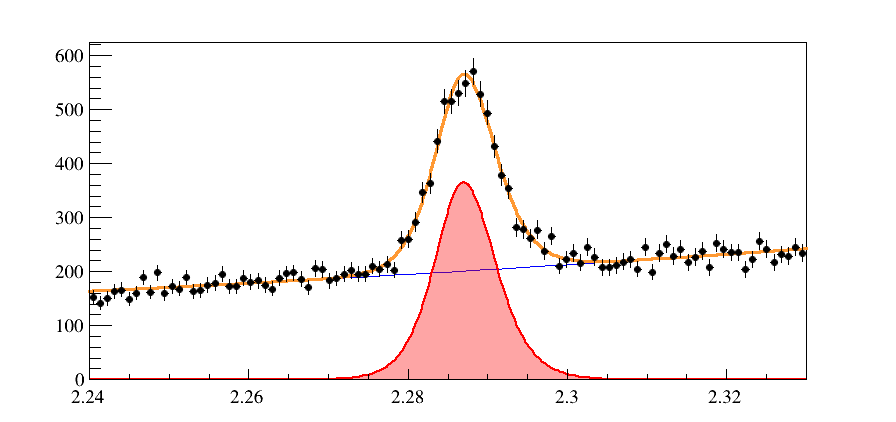

In [4]:
sig = Models.Apollonios2_pdf("sig",xvar=im,mean=(2.287,2.286,2.289),sigma=(0.0045,0.003,0.008),asymmetry=(0.,-0.1,0.1),beta=(1,0.1,20.))
bkg = Models.Bkg_pdf("bkg", xvar=im, power=0)
model = Models.Fit1D(signal=sig, background=bkg)
small_dh = small_ds.reduce(ROOT.RooArgSet(im)).binnedClone()
r,w = model.fitTo(small_dh, draw=True, silent=True)
print(r)
w.Draw()
canv.Draw()


  RooFitResult: minimized FCN value: -279452, estimated distance to minimum: 6.34972e-05
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 HESSE=0 

    Floating Parameter  InitialValue    FinalValue +/-  Error     GblCorr.
  --------------------  ------------  --------------------------  --------
                     B    2.0081e+04    2.0075e+04 +/-  1.78e+02  0.542748
                     S    4.0850e+03    4.0913e+03 +/-  1.25e+02  0.698640
              asym_sig   -5.6928e-02   -5.9170e-02 +/-  5.55e-02  0.932651
              beta_sig    1.6886e+00    1.6176e+00 +/-  4.41e-01  0.937523
              mean_sig    2.2870e+00    2.2870e+00 +/-  3.05e-04  0.931857
             sigma_sig    3.5904e-03    3.5555e-03 +/-  2.37e-04  0.922155
               tau_bkg    4.3743e+00    4.3776e+00 +/-  2.77e-01  0.168894




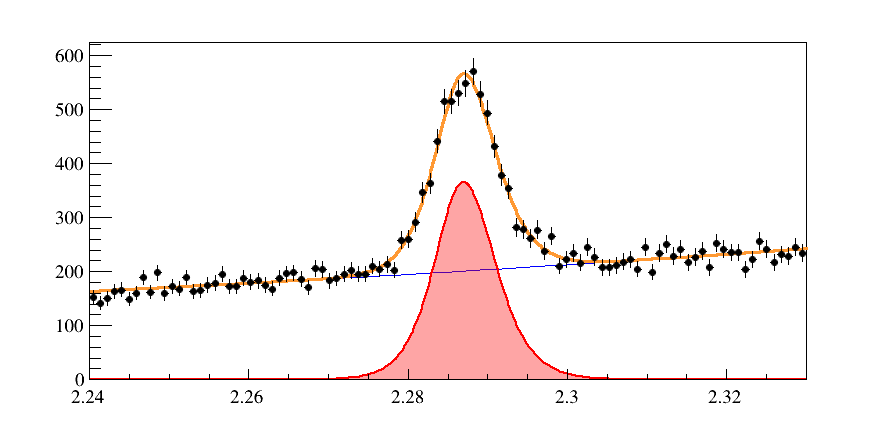

In [5]:
r,w = model.fitTo(small_ds, draw=True, silent=True)
print(r)
w.Draw()
canv.Draw()

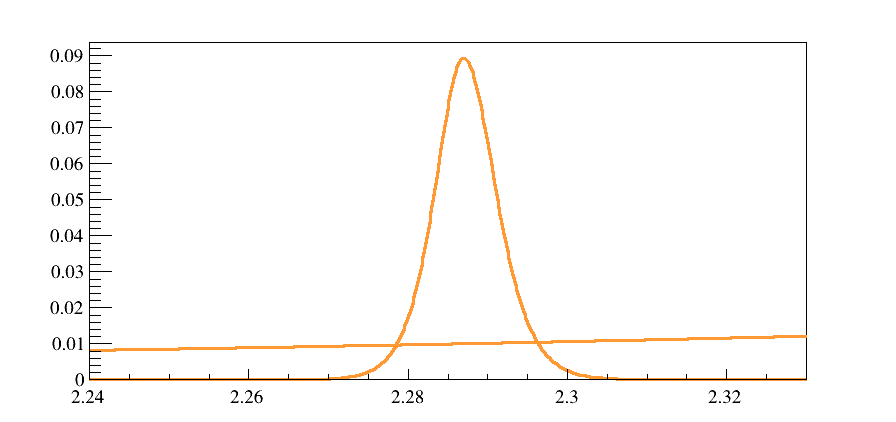

In [8]:
sig_tf = model.signal.pdf.asTF(ROOT.RooArgList(im))
bkg_tf = model.background.pdf.asTF(ROOT.RooArgList(im))
Fs = model.signal.draw()
Fb = model.background.draw()
Fs.Draw()
Fb.Draw("same")
canv.Draw()

In [10]:
peak_pos = r("mean_sig")[0].value()
peak_wdt = r("sigma_sig")[0].value()
S_sig = model.signal.integral(peak_pos - 2.*peak_wdt , peak_pos + 2.*peak_wdt )
B_sig = model.background.integral(peak_pos - 2.*peak_wdt , peak_pos + 2.*peak_wdt )
B_low = model.background.integral(peak_pos - 7.*peak_wdt , peak_pos - 5.*peak_wdt )
B_high= model.background.integral(peak_pos + 5.*peak_wdt , peak_pos + 7.*peak_wdt )
S_tot = model.signal.integral    ( im.getMin(), im.getMax() )
B_tot = model.background.integral( im.getMin(), im.getMax() )
print("SIG (sig.region) : " + str(S_sig/S_tot) )
print("BKG (sig.region) : " + str(B_sig/B_tot) )
print("BKG (sidebands ) : " + str((B_low+B_high)/B_tot))

SIG (sig.region) : 0.8884522260381897
BKG (sig.region) : 0.15838693213956875
BKG (sidebands ) : 0.15905880483214777


Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created


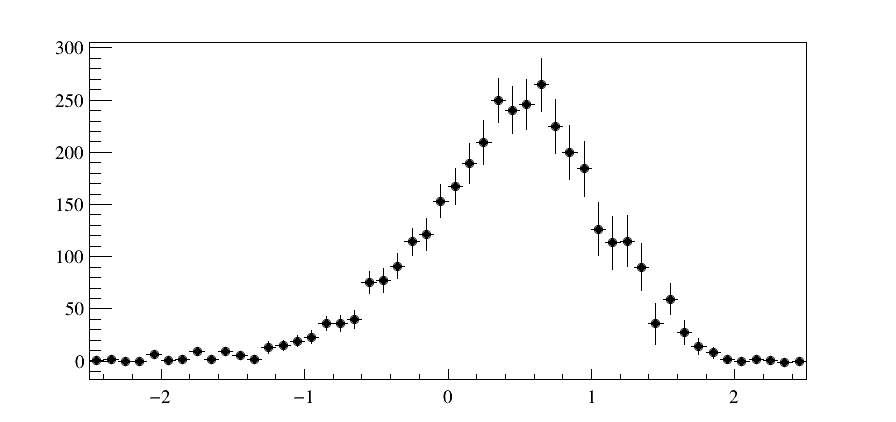

In [27]:
hs  = h1_axis( lgi_bins )
for entry in small_ds:
    if peak_pos - 2.*peak_wdt < entry["im"] and entry["im"]<peak_pos + 2.*peak_wdt :
        hs .Fill( entry["lgi"],  1. )
    if peak_pos - 7.*peak_wdt < entry["im"] and entry["im"]<peak_pos - 5.*peak_wdt :
        hs .Fill( entry["lgi"], -1.*(B_sig/(B_low+B_high)) )
    if peak_pos + 5.*peak_wdt < entry["im"] and entry["im"]<peak_pos + 7.*peak_wdt :
        hs .Fill( entry["lgi"], -1.*(B_sig/(B_low+B_high)) )
hs.Sumw2()
hs.Draw()
canv.Draw()


  RooFitResult: minimized FCN value: -279452, estimated distance to minimum: 4.28314e-13
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 HESSE=0 

    Constant Parameter    Value     
  --------------------  ------------
              asym_sig   -5.9170e-02
              beta_sig    1.6176e+00
              mean_sig    2.2870e+00
             sigma_sig    3.5555e-03
               tau_bkg    4.3776e+00

    Floating Parameter  InitialValue    FinalValue +/-  Error     GblCorr.
  --------------------  ------------  --------------------------  --------
                     B    2.0075e+04    2.0075e+04 +/-  1.58e+02  0.324732
                     S    4.0913e+03    4.0913e+03 +/-  9.46e+01  0.324732




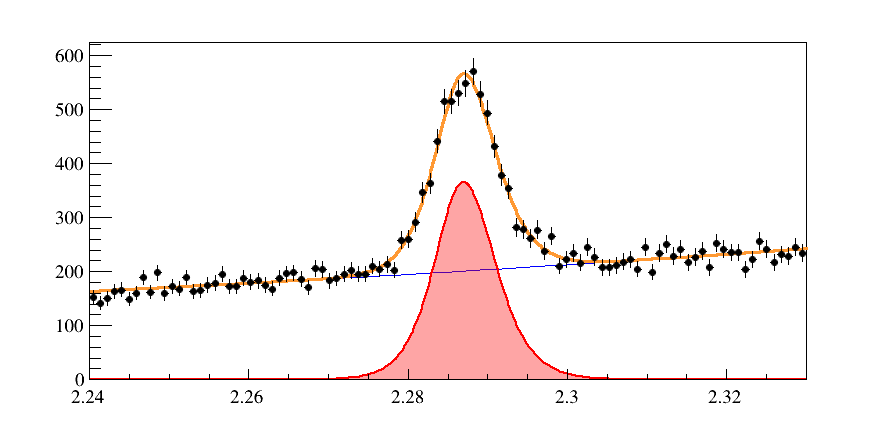

In [28]:
model.signal.mean.fix()
model.signal.sigma.fix()
model.signal.asym.fix()
model.signal.beta.fix()
model.background.tau.fix()
r,w = model.fitTo(small_ds, draw=True, silent=True)
print(r)
w.Draw()
canv.Draw()

+RooDataSet("ds_1000","Ostap.Selectors/ds_1000 "):24166 entries, 6 variables--+
|   Variable    |  Description  |   mean   |   rms    |     min     |   max   |
+---------------+---------------+----------+----------+-------------+---------+
| 1. B_sw       | B_sw          |  +0.8307 | 0.58426  |    -0.32395 | +1.2416 |
| 2. L_B        | L_B           |  +11.237 | 1.1506   |      +9.066 | +13.443 |
| 3. L_S        | L_S           |    +20.5 | 32.937   | +1.6051e-07 | +99.291 |
| 4. S_sw       | S_sw          |  +0.1693 | 0.58421  |    -0.24157 | +1.324  |
| 5. im         | im            |  +2.2879 | 0.025437 |       +2.24 | +2.33   |
| 6. lgi        | lgi           | +0.74469 | 0.59702  |     -2.4785 | +2.472  |
+---------------+---------------+----------+----------+-------------+---------+
( 362.148 +- 9.98053 )
( 409.128 +- 9.45553 )


Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created


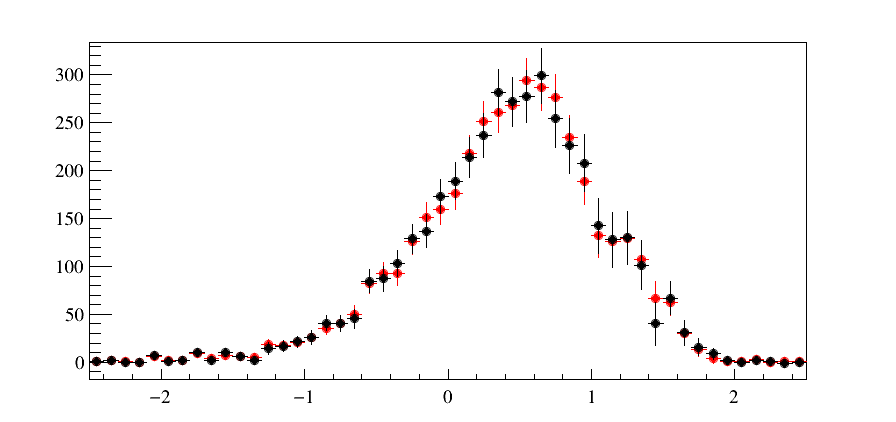

In [29]:
model.sPlot( small_ds )
print(small_ds)
h_sPlot = h1_axis(lgi_bins).red()
h_sPlot.Sumw2()
for entry in small_ds:
    h_sPlot.Fill(entry.lgi,entry.S_sw)
print(hs.integrate())
print(h_sPlot.integrate())
h_sb = hs.clone()*h_sPlot.integrate().value()/hs.integrate().value()
h_sPlot.Draw()
h_sb.Draw("same")
canv.Draw()

In [30]:
help(h_sb.cmp_fit)

Help on method _h1_cmp_fit_ in module ostap.histos.compare:

_h1_cmp_fit_(h2, density=False, opts='0Q') method of ROOT.TH1F instance
    Compare histograms by refit of the first with functions,
    extracted from the second one
    
    >>> h1 = ... ## the first histo
    >>> h2 = ... ## the second histo
    >>> r  = h1.cmp_fit ( h2 )
    >>> if r : print r.Prob()



In [33]:
r_cmp_fit  = h_sb.cmp_fit ( h_sPlot )
if r_cmp_fit : 
    print( r_cmp_fit.Prob() )

0.9999999769564892


In [34]:
help(h_sb.cmp_cos)

Help on method _h1_cmp_costheta_ in module ostap.histos.compare:

_h1_cmp_costheta_(h2, density=False) method of ROOT.TH1F instance
    Compare the 1D-historgams (as functions)
    Calculate scalar product and get ``the angle'' from it
    
    >>> h1 = ... ## the first histo
    >>> h2 = ... ## the second histo
    >>> cos_theta  = h1.cmp_costheta ( h2 )



In [35]:
print( h_sb.cmp_cos ( h_sPlot ) )

( 0.998269 +- 3.23144e-05 )


In [36]:
help(h_sb.cmp_dist)
help(h_sb.cmp_dist2)

Help on method _h1_cmp_dist_ in module ostap.histos.compare:

_h1_cmp_dist_(h2, density=False) method of ROOT.TH1F instance
    Calculate the norm of difference of scaled histograms/functions 
    |f1-f2|, such |f1|=1 and |f2|=1
    
    >>> h1 = ... ## the first histo
    >>> h2 = ... ## the second histo
    >>> diff = h1.cmp_dist ( h2 )

Help on method _h1_cmp_dist2_ in module ostap.histos.compare:

_h1_cmp_dist2_(h2, density=False) method of ROOT.TH1F instance
    Calculate the norm of difference of scaled histograms/functions 
    |(f1-f2)**2/(f1*f2)|, such |f1|=1 and |f2|=1
    
    >>> h1 = ... ## the first histo
    >>> h2 = ... ## the second histo
    >>> diff = h1.cmp_dist2 ( h2 )



In [37]:
print( h_sb.cmp_dist ( h_sPlot ) )
print( h_sb.cmp_dist2( h_sPlot ) )

( 0.000692243 +- 5.68007e-08 )
( 1547.43 +- 86.4695 )


In [40]:
h_sb.cmp_prnt ( h_sPlot , 'h_sb vs h_sPlot ' )

'+h_sb vs h_sPlot  vs h_1140------------+---------------------------+---------------------------+\n| Quantity |     h_sb vs h_sPlot       |          h_1140           |           Delta           |\n+----------+---------------------------+---------------------------+---------------------------+\n| Mean     |     +0.4087 +- 0.01746    |     +0.4106 +- 0.0147     |   -0.001844 +- 0.02283    |\n| Rms      |     +0.6336 +- 0.0145     |     +0.6362 +- 0.01221    |   -0.002614 +- 0.01896    |\n| Skewness |     -0.5595 +- 0.06735    |     -0.5648 +- 0.05652    |   +0.005313 +- 0.08793    |\n| Kurtosis |     +0.7567 +- 0.1342     |     +0.7588 +- 0.1128     |   -0.002174 +- 0.1753     |\n| StdMom/5 |      -2.163 +- 0.5699     |      -2.181 +- 0.4846     |    +0.01832 +- 0.7481     |\n| StdMom/6 |      +7.485 +- 1.895      |      +7.599 +- 1.616      |     -0.1137 +- 2.49       |\n| StdMom/7 |      -17.69 +- 6.201      |       -17.8 +- 5.293      |     +0.1046 +- 8.153      |\n| StdMom/8 |      +

In [41]:
# NOTE that uncertaintie of h_sb and h_sPlot are highly correlated!!